# Imports

In [1]:
import pandas as pd
from xgboost import XGBClassifier as xgbc
from sklearn.ensemble import RandomForestClassifier as rfc
from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

# Download Data

In [2]:
df = pd.read_csv("data/train.csv")

df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


# Data Preprocessing

In [3]:
# Drop irrelevant columns
columns_to_drop = ['PassengerId', 'Name']
df.drop(columns_to_drop, axis=1, inplace=True)

# Split the 'Cabin' column into 'Deck', 'CabinNumber', and 'Side'
df['Deck'] = df['Cabin'].str.extract(r'([A-Za-z])')  # Extract the first letter (Deck)
df['CabinNumber'] = df['Cabin'].str.extract(r'(\d+)')  # Extract the digits (Cabin number)
df['Side'] = df['Cabin'].str.extract(r'([PS])')  # Extract the side ('P' for Port, 'S' for Starboard)

# Drop the original 'Cabin' column after the split
df.drop('Cabin', axis=1, inplace=True)

# Combine all the spending features into a single total spend feature
spend_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
df[spend_cols] = df[spend_cols].fillna(0)  # Fill missing spending data with 0
df['TotalSpend'] = df[spend_cols].sum(axis=1)  # Create TotalSpend as the sum of all spending features

# Fill missing values for each of the extracted features
df['Deck'] = df['Deck'].fillna('None')
df['CabinNumber'] = df['CabinNumber'].fillna('None')
df['Side'] = df['Side'].fillna('None')

# Fill missing boolean values (CryoSleep) with false if spenditure was 0
df['CryoSleep'] = df['CryoSleep'].fillna(df['TotalSpend'] == 0).astype(bool)

# Filter the DataFrame to get the rows where VIP is True
vip_df = df[df['VIP'] == True]

# Calculate the average spending of VIPs
avg_vip_spend = vip_df['TotalSpend'].mean()

# Use this average to set the spending threshold
# Fill missing VIP values based on whether TotalSpend exceeds the average VIP spend
df['VIP'] = df['VIP'].fillna(df['TotalSpend'] > avg_vip_spend)

# Fill missing numerical values for 'Age' with the median
df['Age'] = df['Age'].fillna(df['Age'].median())

# Fill missing categorical values for 'HomePlanet' and 'Destination' with the most common value (mode)
df['HomePlanet'] = df['HomePlanet'].fillna(df['HomePlanet'].mode()[0])
df['Destination'] = df['Destination'].fillna(df['Destination'].mode()[0])

# Encode HomePlanet
le_homeplanet = LabelEncoder()
df['HomePlanet'] = le_homeplanet.fit_transform(df['HomePlanet'].astype(str))

# Encode Destination
le_destination = LabelEncoder()
df['Destination'] = le_destination.fit_transform(df['Destination'].astype(str))

# Encode Deck
le_deck = LabelEncoder()
df['Deck'] = le_deck.fit_transform(df['Deck'].astype(str))

# Encode CabinNumber
le_cabinnumber = LabelEncoder()
df['CabinNumber'] = le_cabinnumber.fit_transform(df['CabinNumber'].astype(str))

# Encode Side
le_side = LabelEncoder()
df['Side'] = le_side.fit_transform(df['Side'].astype(str))

# Convert CryoSleep and VIP to int
df['CryoSleep'] = df['CryoSleep'].astype(int)
df['VIP'] = df['VIP'].astype(int)

df.drop('TotalSpend', axis=1, inplace=True)

df.head()

C:\Users\Santiago\AppData\Local\Temp\ipykernel_24064\1211600779.py:24: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['CryoSleep'] = df['CryoSleep'].fillna(df['TotalSpend'] == 0).astype(bool)
C:\Users\Santiago\AppData\Local\Temp\ipykernel_24064\1211600779.py:34: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['VIP'] = df['VIP'].fillna(df['TotalSpend'] > avg_vip_spend)


,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,CabinNumber,Side
0,1,0,2,39.0,0,0.0,0.0,0.0,0.0,0.0,False,1,0,1
1,0,0,2,24.0,0,109.0,9.0,25.0,549.0,44.0,True,5,0,2
2,1,0,2,58.0,1,43.0,3576.0,0.0,6715.0,49.0,False,0,0,2
3,1,0,2,33.0,0,0.0,1283.0,371.0,3329.0,193.0,False,0,0,2
4,0,0,2,16.0,0,303.0,70.0,151.0,565.0,2.0,True,5,1,2


# Splitting the dataset

In [4]:
# Define features (X) and target (y)
X = df.drop('Transported', axis=1)  # All columns except 'Transported' are features
y = df['Transported']  # 'Transported' is the target variable

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = tts(X, y, test_size=0.2, random_state=42)

# Check the shape of the resulting datasets
print(f'Training set size: {X_train.shape}')
print(f'Testing set size: {X_test.shape}')

Training set size: (6954, 13)
Testing set size: (1739, 13)


# Random Forest

In [5]:
my_RandomForest = rfc(n_estimators=30, bootstrap=True, random_state=2)
my_RandomForest.fit(X_train, y_train)

rfc_predict = my_RandomForest.predict(X_test)
rfc_prob = my_RandomForest.predict_proba(X_test)[:, 1]

accuracy_rf = accuracy_score(y_test, rfc_predict)
auc_rf = roc_auc_score(y_test, rfc_prob)

print(f"AUC of Random Forest: {auc_rf:.4f}")
print(f"Accuracy of Random Forest: {accuracy_rf:.4f}")

AUC of Random Forest: 0.8698
Accuracy of Random Forest: 0.7941


# XGBoost

In [9]:
# Initialize the XGBoost classifier
my_XGBoost = xgbc(n_estimators = 30,random_state=2)

# Train the XGBoost model using the training data
my_XGBoost.fit(X_train, y_train)

# Make predictions on the test dataset (class labels: 0 or 1)
xgb_preds = my_XGBoost.predict(X_test)

# Get predicted probabilities for the positive class (malignant cancer)
xgb_probs = my_XGBoost.predict_proba(X_test)[:, 1]

# Calculate the accuracy of the xgb
xgb_accuracy = accuracy_score(y_test, xgb_preds)

auc_xgb = roc_auc_score(y_test, xgb_probs)

# Print accuracy and AUC score to evaluate XGBoost's performance
print(f"XGBoost AUC: {auc_xgb:.4f}")
print(F"XGBoost Accuracy: {xgb_accuracy:.4f}")

XGBoost AUC: 0.8867
XGBoost Accuracy: 0.7959


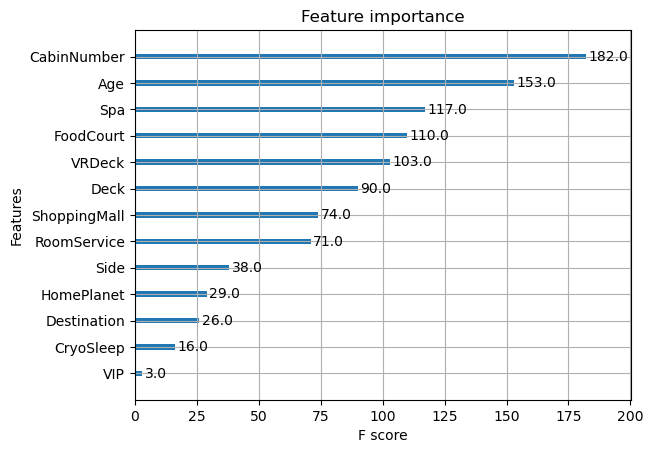

In [7]:
from xgboost import plot_importance

# Plot feature importance
plot_importance(my_XGBoost)
plt.show()

# Comparison

In [46]:
# Store the accuracy scores
accuracy_scores = []
auc_scores = []

models = {
    'Random Forest': my_RandomForest,
    'XGBoost': my_XGBoost,
}

accuracy_scores.append(accuracy_rf)
accuracy_scores.append(xgb_accuracy)

auc_scores.append(auc_rf)
auc_scores.append(auc_xgb)

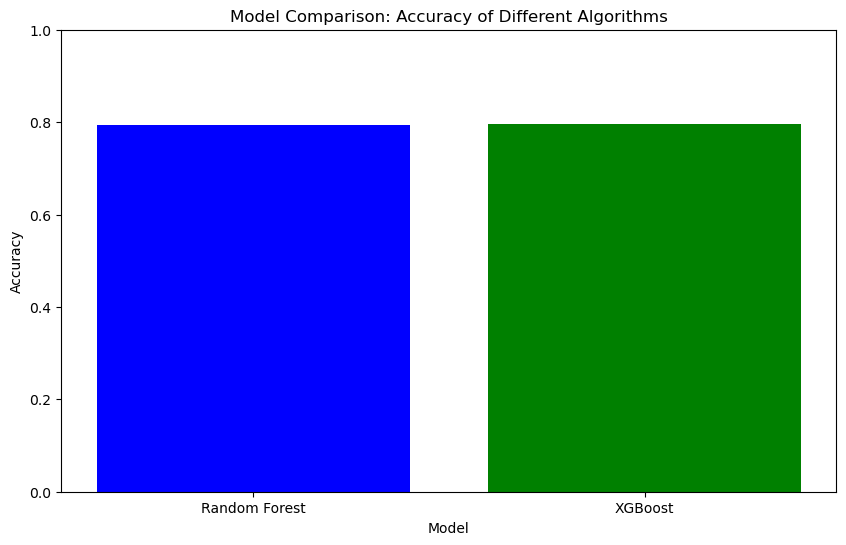

In [47]:
# Create a bar plot to compare the accuracy of models
plt.figure(figsize=(10, 6))
plt.bar(models.keys(), accuracy_scores, color=['blue', 'green', 'red', 'purple', 'orange'])
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Comparison: Accuracy of Different Algorithms')
plt.ylim(0, 1)  # Accuracy range from 0 to 1
plt.show()

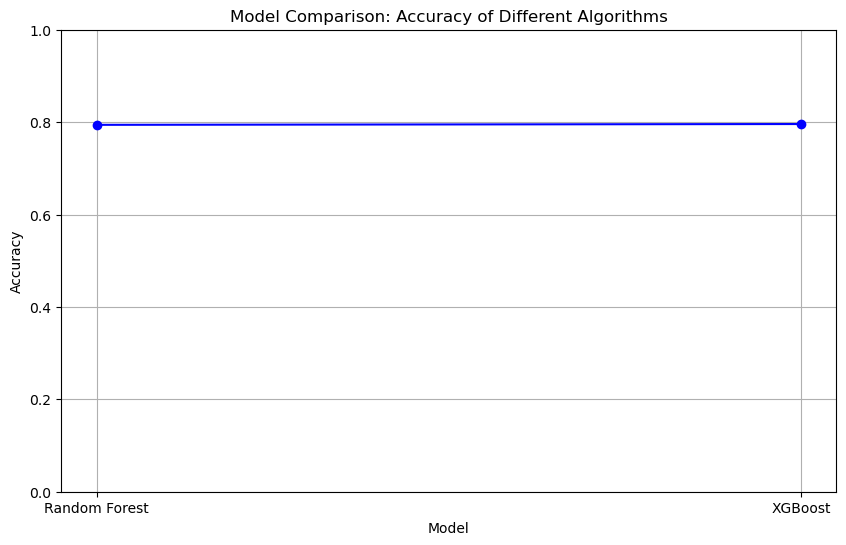

In [48]:
# Create a line plot to compare the accuracy of models
plt.figure(figsize=(10, 6))
plt.plot(models.keys(), accuracy_scores, marker='o', linestyle='-', color='b', label='Accuracy')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Comparison: Accuracy of Different Algorithms')
plt.ylim(0, 1)  # Accuracy range from 0 to 1
plt.grid(True)
plt.show()

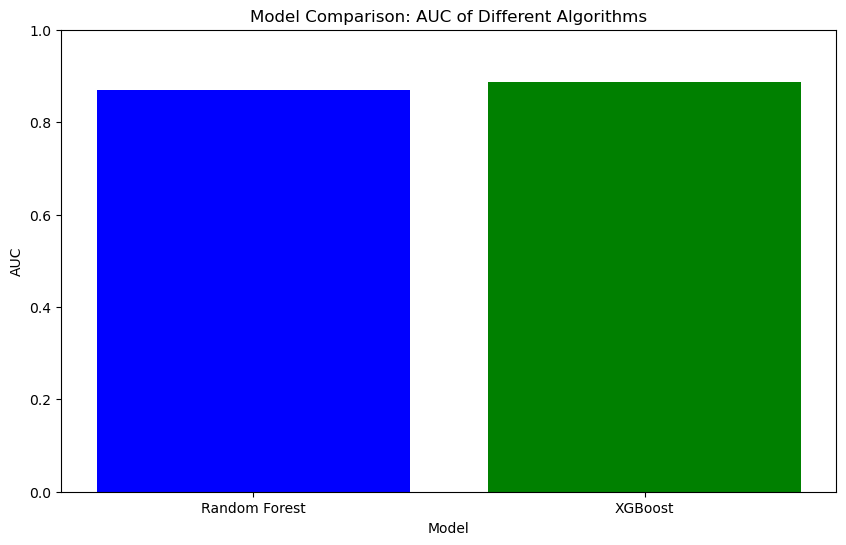

In [49]:
# Create a bar plot to compare the accuracy of models
plt.figure(figsize=(10, 6))
plt.bar(models.keys(), auc_scores, color=['blue', 'green', 'red', 'purple', 'orange'])
plt.xlabel('Model')
plt.ylabel('AUC')
plt.title('Model Comparison: AUC of Different Algorithms')
plt.ylim(0, 1)  # Accuracy range from 0 to 1
plt.show()

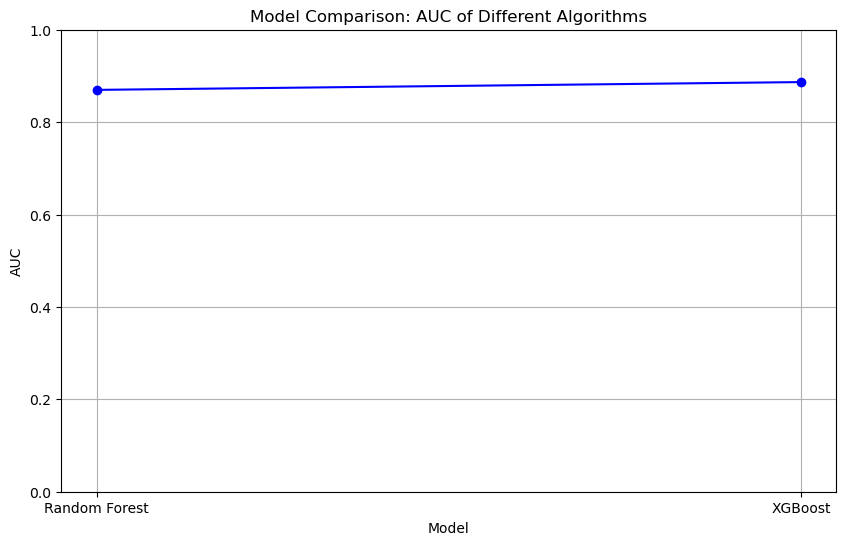

In [50]:
# Create a line plot to compare the accuracy of models
plt.figure(figsize=(10, 6))
plt.plot(models.keys(), auc_scores, marker='o', linestyle='-', color='b', label='Accuracy')
plt.xlabel('Model')
plt.ylabel('AUC')
plt.title('Model Comparison: AUC of Different Algorithms')
plt.ylim(0, 1)  # Accuracy range from 0 to 1
plt.grid(True)
plt.show()

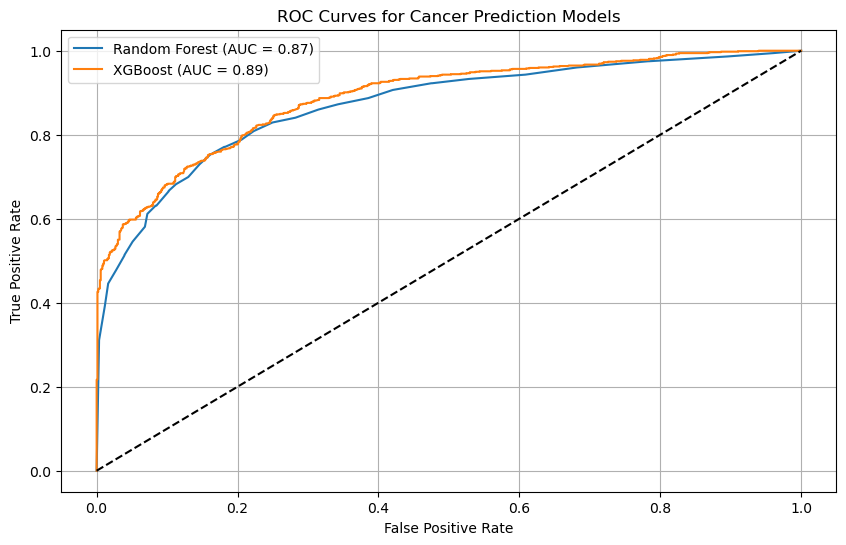

In [52]:
%matplotlib inline

plt.figure(figsize=(10, 6))

# Function to plot the ROC curve
def plot_roc_curve(y_test, probs, label):
    fpr, tpr, _ = roc_curve(y_test, probs)
    plt.plot(fpr, tpr, label=f"{label} (AUC = {roc_auc_score(y_test, probs):.2f})")

# Plot ROC curves for Random Forest and XGBoost
plot_roc_curve(y_test, rfc_prob, "Random Forest")
plot_roc_curve(y_test, xgb_probs, "XGBoost")

# Plot random baseline (AUC = 0.5)
plt.plot([0, 1], [0, 1], "k--")

# Labels and title
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Cancer Prediction Models")

# Legend and grid
plt.legend()
plt.grid(True)

# Show plot
plt.show()